### Checking zonal winters ###

Checking whether it is plausible that the block maxima demand net wind day
for a given winter could be zonal.

In [19]:
# Local imports
import os
import sys
import glob
import time
import json
import argparse

# Third-party imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import iris

# Specific imports
from tqdm import tqdm
from datetime import datetime, timedelta

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [ ]:
# Set up the hard-coded variables and paths
test_init_year = 1984
test_mem = 4
test_lead = 3336
test_winter_year = 10
members_list = np.array([10, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Set up the directories in which the data are stored
arrs_dir = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_arrs/model/"
# dfs_dir = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs/"
local_df_dir = "/home/users/benhutch/unseen_multi_year/dfs"
metadata_dir = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_arrs/metadata/"

# Set up the fnames for the variables
test_fname_1984 = "HadGEM3-GC31-MM_psl_NA_1984_DJF_day.npy"
test_fname_1984_tas = "HadGEM3-GC31-MM_tas_Europe_1984_DJF_day.npy"
test_fname_1984_wind = "HadGEM3-GC31-MM_sfcWind_Europe_1984_DJF_day.npy
df_fname = "full_field_model_tas_wind_UK_1961-2024_DJF_detrended_01-07-2025_dnw.csv"
lats_NA_fname = "HadGEM3-GC31-MM_psl_NA_1960_DJF_day_lats.npy"
lons_NA_fname = "HadGEM3-GC31-MM_psl_NA_1960_DJF_day_lons.npy"

In [3]:
# --------------------
# Load in the csv data
# --------------------

df = pd.read_csv(os.path.join(local_df_dir, df_fname), index_col=0, parse_dates=True)

In [4]:
df.head()

,member,lead,data_tas,data_sfcWind,delta_p_hpa,data_uas,data_vas,winter_year,effective_dec_year,data_tas_c,...,normalized_dec_year,trend_value,data_tas_c_drift_bc_dt,data_tas_c_dt,hdd,cdd,data_tas_c_drift_bc_dt_UK_demand,data_tas_c_dt_UK_demand,demand_net_wind,demand_net_wind_bc
init_year,,,,,,,,,,,,,,,,,,,,,
1960-01-01,1,391,279.235872,6.630821,-3.40560,-0.751132,6.093479,2,1961,6.085872,...,0,2.92305,8.455896,8.518555,6.981445,0,40.322320,40.275475,29.418947,29.465792
1960-01-01,1,392,277.786144,6.412853,-5.44755,-2.055767,4.445771,2,1961,4.636144,...,0,2.92305,7.006168,7.068827,8.431173,0,41.406150,41.359305,32.596305,32.643149
1960-01-01,1,393,275.855490,4.780915,-2.12340,-2.457284,1.679573,2,1961,2.705490,...,0,2.92305,5.075514,5.138174,10.361826,0,42.849523,42.802678,27.715327,27.762171
1960-01-01,1,394,276.019276,5.366350,2.73710,-3.810673,2.807081,2,1961,2.869276,...,0,2.92305,5.239300,5.301960,10.198040,0,42.727075,42.680230,30.581747,30.628591
1960-01-01,1,395,276.401608,4.608913,-1.38540,-2.410317,3.197820,2,1961,3.251608,...,0,2.92305,5.621632,5.684291,9.815709,0,42.441241,42.394396,19.671251,19.718095


In [ ]:
%%time
# ----------------------
# Load in the numpy array data
# ----------------------

arrs = np.load(os.path.join(arrs_dir, test_fname_1984))

# load the arr tas
arrs_tas = np.load(os.path.join(arrs_dir, test_fname_1984_tas))
# load the arr wind
arrs_wind = np.load(os.path.join(arrs_dir, test_fname_1984_wind))

In [6]:
# Print the shape of the loaded array
print(f"Shape of the loaded array: {arrs.shape}")

Shape of the loaded array: (1, 10, 3750, 90, 96)


In [ ]:
# ------------------------
# Now we want to find the index of the leads for the test winter year
# ------------------------

# Define the winter years
winter_year = np.arange(1, 11 + 1)

# Set up a dictionary for the indices
indices_dict = {}

# Loop through the winter years and find the indices
for i, wyear in enumerate(winter_year):
    # set up the leads_djf to extract
    leads_djf = np.arange(31 + (i * 360), 31 + 90 + (i * 360))

    leads_djs_indices = leads_djf - 1

    # Prin the wyear and the min amd max index
    print(
        f"Winter year: {wyear}, Min index: {leads_djs_indices.min()}, Max index: {leads_djs_indices.max()}"
    )

    # Store the indices in the dictionary
    indices_dict[wyear] = leads_djs_indices

Winter year: 1, Min index: 30, Max index: 119
Winter year: 2, Min index: 390, Max index: 479
Winter year: 3, Min index: 750, Max index: 839
Winter year: 4, Min index: 1110, Max index: 1199
Winter year: 5, Min index: 1470, Max index: 1559
Winter year: 6, Min index: 1830, Max index: 1919
Winter year: 7, Min index: 2190, Max index: 2279
Winter year: 8, Min index: 2550, Max index: 2639
Winter year: 9, Min index: 2910, Max index: 2999
Winter year: 10, Min index: 3270, Max index: 3359
Winter year: 11, Min index: 3630, Max index: 3719


In [ ]:
# --------------------------
# Now we want to extract the data for the test winter year, and test member
# --------------------------

# Find the indices for the test winter year
test_winter_indices = indices_dict[test_winter_year]

# Find the index of the ensmember in the members_list
test_member_index = np.where(members_list == test_mem)[0][0]

# Extract the data for the test winter year and test member
test_winter_data = arrs[0, test_member_index, test_winter_indices, :, :]
test_winter_data_tas = arrs_tas[0, test_member_index, test_winter_indices, :, :]
test_winter_data_wind = arrs_wind[0, test_member_index, test_winter_indices, :, :]

# Print the shape of the extracted data
print(
    f"Shape of the extracted data for winter year {test_winter_year} and member {test_mem}: {test_winter_data.shape}"
)

Shape of the extracted data for winter year 10 and member 4: (90, 90, 96)


In [12]:
df.head()

,init_year,member,lead,data_tas,data_sfcWind,delta_p_hpa,data_uas,data_vas,winter_year,effective_dec_year,...,normalized_dec_year,trend_value,data_tas_c_drift_bc_dt,data_tas_c_dt,hdd,cdd,data_tas_c_drift_bc_dt_UK_demand,data_tas_c_dt_UK_demand,demand_net_wind,demand_net_wind_bc
0,1960-01-01,1,391,279.235872,6.630821,-3.40560,-0.751132,6.093479,2,1961,...,0,2.92305,8.455896,8.518555,6.981445,0,40.322320,40.275475,29.418947,29.465792
1,1960-01-01,1,392,277.786144,6.412853,-5.44755,-2.055767,4.445771,2,1961,...,0,2.92305,7.006168,7.068827,8.431173,0,41.406150,41.359305,32.596305,32.643149
2,1960-01-01,1,393,275.855490,4.780915,-2.12340,-2.457284,1.679573,2,1961,...,0,2.92305,5.075514,5.138174,10.361826,0,42.849523,42.802678,27.715327,27.762171
3,1960-01-01,1,394,276.019276,5.366350,2.73710,-3.810673,2.807081,2,1961,...,0,2.92305,5.239300,5.301960,10.198040,0,42.727075,42.680230,30.581747,30.628591
4,1960-01-01,1,395,276.401608,4.608913,-1.38540,-2.410317,3.197820,2,1961,...,0,2.92305,5.621632,5.684291,9.815709,0,42.441241,42.394396,19.671251,19.718095


In [11]:
# reset the index of the df
df.reset_index(inplace=True)

In [ ]:
# -------------------------
# Subset the df for the same init year, member, winter year
# -------------------------

# Format test_init_year as a datetime YYYY
test_init_year_dt = datetime.strptime(str(test_init_year), "%Y")

# Subset the df for the same init year, member, winter year
df_subset = df[
    (df["init_year"] == test_init_year_dt)
    & (df["member"] == test_mem)
    & (df["winter_year"] == test_winter_year)
]

In [14]:
df_subset.head()

,init_year,member,lead,data_tas,data_sfcWind,delta_p_hpa,data_uas,data_vas,winter_year,effective_dec_year,...,normalized_dec_year,trend_value,data_tas_c_drift_bc_dt,data_tas_c_dt,hdd,cdd,data_tas_c_drift_bc_dt_UK_demand,data_tas_c_dt_UK_demand,demand_net_wind,demand_net_wind_bc
240480,1984-01-01,4,3271,281.597649,11.271829,-28.42560,6.957100,8.050522,10,1993,...,32,3.646752,10.542859,10.156630,5.343370,0,38.762089,39.050836,30.409567,30.120819
240481,1984-01-01,4,3272,279.940397,9.146608,-30.72225,6.841148,3.997444,10,1993,...,32,3.646752,8.885607,8.499378,7.000622,0,40.001064,40.289812,36.743400,36.454653
240482,1984-01-01,4,3273,277.226096,7.877663,-28.51240,5.134559,4.179133,10,1993,...,32,3.646752,6.171305,5.785077,9.714923,0,42.030300,42.319048,27.168555,26.879808
240483,1984-01-01,4,3274,280.141681,10.281603,-31.83120,6.091688,8.112021,10,1993,...,32,3.646752,9.086890,8.700662,6.799338,0,39.850583,40.139331,20.614156,20.325408
240484,1984-01-01,4,3275,281.476372,10.513037,-37.57205,7.874454,5.701714,10,1993,...,32,3.646752,10.421582,10.035353,5.464647,0,38.852756,39.141504,26.493426,26.204678


In [ ]:
# Extract the row where demand net wind bc is highest
max_demand_net_wind_bc_row = df_subset.loc[df_subset["demand_net_wind_bc"].idxmax()]

# Print the row with the maximum demand net wind bc
print("Row with maximum demand net wind bc:")
print(max_demand_net_wind_bc_row)

Row with maximum demand net wind bc:
init_year                           1984-01-01 00:00:00
member                                                4
lead                                               3336
data_tas                                     277.045665
data_sfcWind                                  11.812768
delta_p_hpa                                    -46.0894
data_uas                                      10.821542
data_vas                                       4.086221
winter_year                                          10
effective_dec_year                                 1993
data_tas_c                                     3.895665
data_tas_c_anomaly                             0.525954
data_tas_c_drift_bc                            4.999498
wind_cfs                                       0.177292
total_gen                                      5.397419
normalized_dec_year                                  32
trend_value                                    3.646752
data_tas_c_

In [ ]:
# -------------------
# import the lats and lons to plot
# -------------------

lats_arr = np.load(os.path.join(metadata_dir, lats_NA_fname))
lons_arr = np.load(os.path.join(metadata_dir, lons_NA_fname))

lats_arr_tas
lons_arr_tas

lats_arr_wind
lons_arr_wind

100%|██████████| 90/90 [00:00<00:00, 221.24it/s]


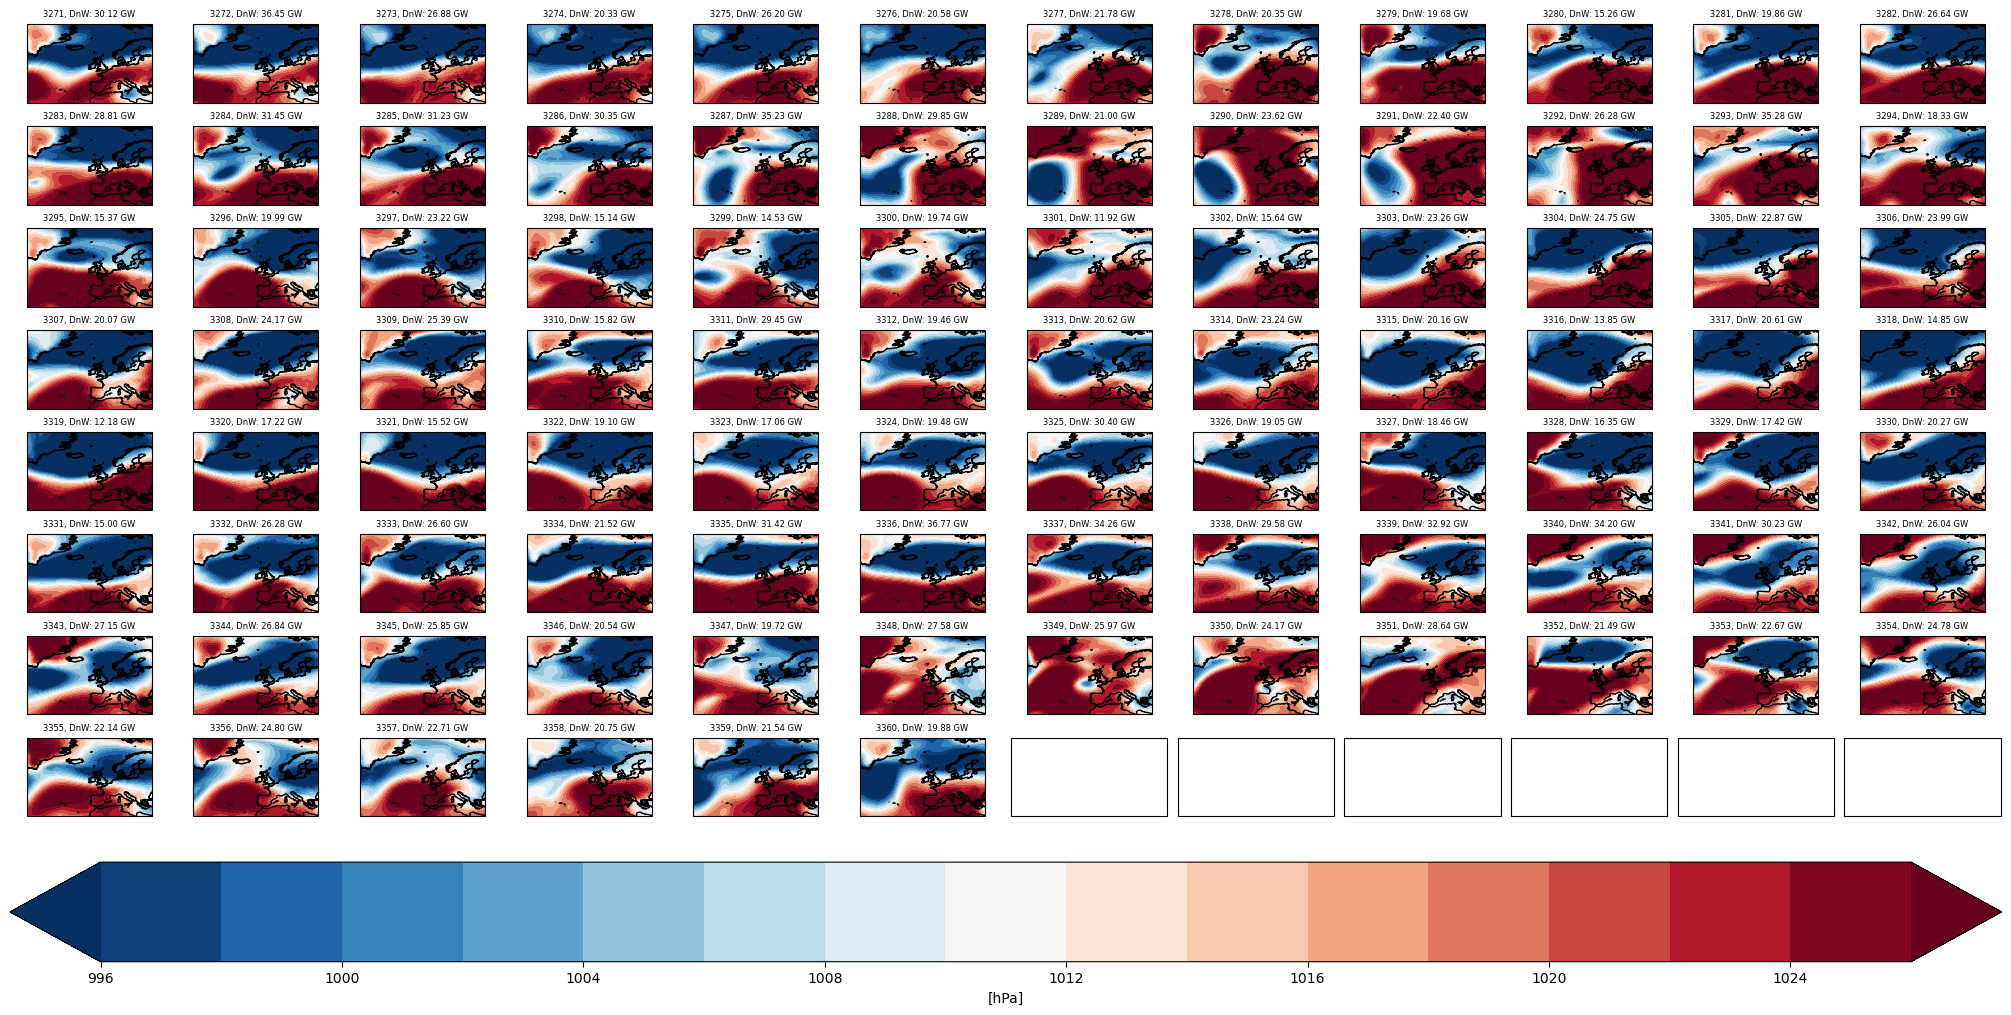

In [22]:
# ---------------------
# Loop over and plot this winter with dnw bc values
# ---------------------

# Set up the levels
levels_psl_abs = np.array(
    [
        996,
        998,
        1000,
        1002,
        1004,
        1006,
        1008,
        1010,
        1012,
        1014,
        1016,
        1018,
        1020,
        1022,
        1024,
        1026,
    ]
)

# Set up a figure with 12 columns and 8 rows
nrows = 8
ncols = 12

# Set up the figsize x
figsize_x = 20
figsize_y = 10

fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(figsize_x, figsize_y),
    subplot_kw={"projection": ccrs.PlateCarree()},
    layout="constrained",
)

n_day = test_winter_data.shape[0]

# Loop over the days in the test winter data
for i in tqdm(range(n_day)):
    # Get the current day data
    day_data = test_winter_data[i, :, :]

    # Get the current ax
    ax = axs[i // ncols, i % ncols]

    # get the lead this from the df
    lead_this = df_subset.iloc[i]["lead"]

    # Set up the dnw this
    dnw_this = df_subset.iloc[i]["demand_net_wind_bc"]

    # Plot the data on the ax
    im = ax.contourf(
        lons_arr,
        lats_arr,
        day_data / 100, # Convert from Pa to hPa
        cmap="RdBu_r",
        levels=levels_psl_abs,
        extend="both",
        transform=ccrs.PlateCarree(),
    )

    # Set up the title
    title_this = (
        f"{lead_this}, "
        f"DnW: {dnw_this:.2f} GW"
    )
    ax.set_title(title_this, fontsize=6)

    # Add coastlines
    ax.coastlines()

# Set up the cbar
cbar = fig.colorbar(im, ax=axs, orientation="horizontal", pad=0.05)
cbar.set_label("[hPa]")

In [ ]:
import matplotlib.animation as animation

# Function to update each frame
def update(frame):
    ax.clear()
    im = ax.contourf(
        lons_arr,
        lats_arr,
        test_winter_data[frame, :, :] / 100,  # Convert from Pa to hPa
        cmap="RdBu_r",
        levels=levels_psl_abs,
        extend="both",
        transform=ccrs.PlateCarree(),
    )
    lead_this = df_subset.iloc[frame]["lead"]
    dnw_this = df_subset.iloc[frame]["demand_net_wind_bc"]
    wind_gen_this = df_subset.iloc[frame]["wind_generation"]
    demand_this = df_subset.iloc[frame]["demand"]
    ax.set_title(f"{lead_this}, DnW: {dnw_this:.2f} GW", fontsize=10)
    ax.coastlines()
    return [im]

# Set up the figure and axis for animation
fig_anim, ax = plt.subplots(
    figsize=(8, 6),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

ani = animation.FuncAnimation(
    fig_anim,
    update,
    frames=n_day,
    blit=False
)

# Save as GIF
ani.save("winter_evolution.gif", writer="pillow", fps=2)
plt.close(fig_anim)

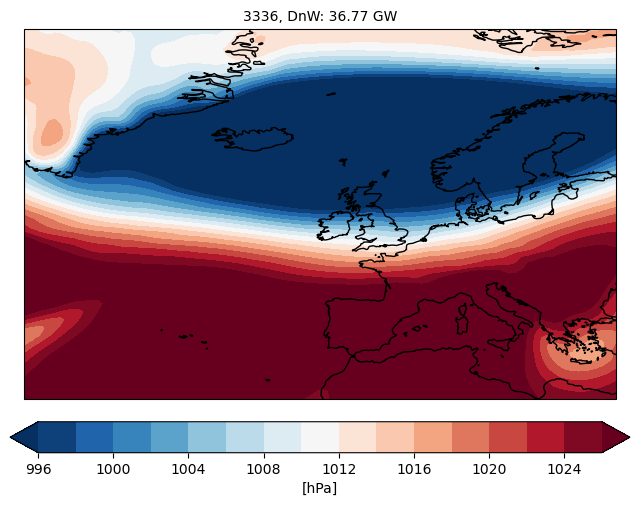

In [23]:
# Plot the worst day (highest demand net wind bc) as a single plot

# Get the index of the worst day in df_subset
worst_day_idx = df_subset["demand_net_wind_bc"].idxmax()
worst_day_row = df_subset.loc[worst_day_idx]

# Find the corresponding day index in test_winter_data
worst_day_pos = df_subset.index.get_loc(worst_day_idx)
worst_day_data = test_winter_data[worst_day_pos, :, :]

fig_worst, ax_worst = plt.subplots(
    figsize=(8, 6),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

im_worst = ax_worst.contourf(
    lons_arr,
    lats_arr,
    worst_day_data / 100,  # Convert from Pa to hPa
    cmap="RdBu_r",
    levels=levels_psl_abs,
    extend="both",
    transform=ccrs.PlateCarree(),
)

title_worst = (
    f"{worst_day_row['lead']}, "
    f"DnW: {worst_day_row['demand_net_wind_bc']:.2f} GW"
)
ax_worst.set_title(title_worst, fontsize=10)
ax_worst.coastlines()

cbar_worst = fig_worst.colorbar(im_worst, ax=ax_worst, orientation="horizontal", pad=0.05)
cbar_worst.set_label("[hPa]")
plt.show()